In [20]:
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point, Polygon, LineString
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from geopy.distance import geodesic

from typing import List, Dict, Tuple, Optional

In [77]:
df = pd.read_csv("../data/ECML:PKDD15.csv")
df.head()

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [6]:
df = df[df.MISSING_DATA != True]
df = df[df.POLYLINE != '[]']
df['DATETIME'] = df.TIMESTAMP.apply(lambda x: dt.datetime.fromtimestamp(x))

In [7]:
df['DATETIME'] = df.TIMESTAMP.apply(lambda x: dt.datetime.fromtimestamp(x))
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,DATETIME
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 03:08:23
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 03:02:31
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",2013-07-01 03:00:54
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",2013-07-01 03:04:51


In [56]:
sample = df.iloc[:3]
sample

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,DATETIME
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 03:08:23
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 03:02:31


In [57]:
sample["TRAJ"] = sample.POLYLINE.apply(lambda x: LineString(eval(x)))
sample.head()

<ipython-input-57-011df993c3e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["TRAJ"] = sample.POLYLINE.apply(lambda x: LineString(eval(x)))


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,DATETIME,TRAJ
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"LINESTRING (-8.618643 41.141412, -8.618499 41...."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 03:08:23,"LINESTRING (-8.639847 41.159826, -8.6403510000..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",2013-07-01 03:02:31,"LINESTRING (-8.612964 41.140359, -8.6133780000..."


In [35]:
gsample = gp.GeoDataFrame(sample, geometry="TRAJ")

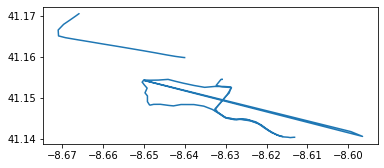

In [36]:
gsample.TRAJ.plot()

In [58]:
sample["LIST"] = sample.POLYLINE.apply(lambda x: eval(x))

<ipython-input-58-a65b58bebeff>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample["LIST"] = sample.POLYLINE.apply(lambda x: eval(x))


In [59]:
def to_segments(line, step=5):
    return [line[i-step: i+1] for i in range(step, len(line) - 1, step)]

In [62]:
STEP = 5
sample["SEGMENT"] = sample.LIST.apply(to_segments)
sample = sample.explode("SEGMENT").reset_index()
sample["SEGMENT"] = sample["SEGMENT"].apply(lambda x: LineString(x))

In [64]:
gsample = gp.GeoDataFrame(sample, geometry="SEGMENT")

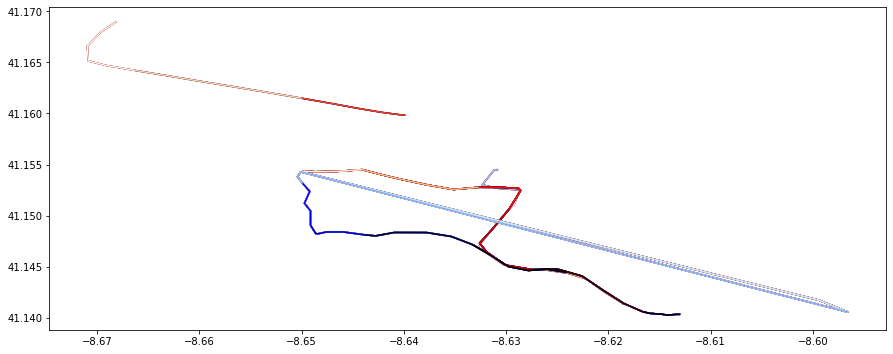

In [72]:
gsample.SEGMENT.plot(cmap='flag', figsize=(15,15))

In [46]:
gsample.SEGMENT[0].coords.xy

(array('d', [-8.618643, -8.618499, -8.620326, -8.622153, -8.623953]),
 array('d', [41.141412, 41.141376, 41.14251, 41.143815, 41.144373]))

In [86]:
def remove_missing(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df.MISSING_DATA != True]
    df = df[df.POLYLINE != '[]']
    return df

def convert_datetime(df: pd.DataFrame) -> pd.DataFrame:
    df['DATETIME'] = df.TIMESTAMP.apply(lambda x: dt.datetime.fromtimestamp(x))
    return df


def to_segments(line: List[List[int]], step: int) -> List[List[List[int]]]:
    return [line[i-step: i+1] for i in range(step, len(line) - 1, step)]


def divide_into_segments(df: pd.DataFrame, segment_step: int) -> pd.DataFrame:    
    df["LIST"] = df.POLYLINE.apply(lambda x: eval(x))
    df["SEGMENT"] = df.LIST.apply(lambda x: to_segments(x, segment_step))
    df = df.explode("SEGMENT").reset_index()
    return df


def preprocess(df: pd.DataFrame, segment_step: int = 5) -> pd.DataFrame:
    df = (df
        .pipe(remove_missing)
        .pipe(convert_datetime)
        .pipe(divide_into_segments, segment_step=segment_step)
    )
    return df

def convert_to_geom(df: pd.DataFrame, geometry_column: str) -> gp.GeoDataFrame:
    df[f"{geometry_column}_geom"] = df[geometry_column].apply(lambda x: LineString(x))
    return gp.GeoDataFrame(df, geometry=geometry_column)


In [89]:
df = pd.read_csv("../data/ECML:PKDD15.csv").drop(columns=["CALL_TYPE", "ORIGIN_CALL", "ORIGIN_STAND", "DAY_TYPE"])
df.head()

,TRIP_ID,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE
0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,20000320,1372636951,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,20000520,1372636854,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,20000337,1372637091,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [97]:
preproc_df = preprocess(df.copy())

In [91]:
preproc_df.head()

,index,TRIP_ID,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,DATETIME,LIST,SEGMENT
0,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.62668, 41.144778], [-8.627373, 41.144697]..."
2,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.629938, 41.150385], [-8.62911, 41.151213]..."
3,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.628759, 41.152518], [-8.630838, 41.15268]..."
4,1,1372637303620000596,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 03:08:23,"[[-8.639847, 41.159826], [-8.640351, 41.159871...","[[-8.639847, 41.159826], [-8.640351, 41.159871..."


In [95]:
print(*preproc_df.head().SEGMENT, sep="\n")

[[-8.618643, 41.141412], [-8.618499, 41.141376], [-8.620326, 41.14251], [-8.622153, 41.143815], [-8.623953, 41.144373], [-8.62668, 41.144778]]
[[-8.62668, 41.144778], [-8.627373, 41.144697], [-8.630226, 41.14521], [-8.632746, 41.14692], [-8.631738, 41.148225], [-8.629938, 41.150385]]
[[-8.629938, 41.150385], [-8.62911, 41.151213], [-8.629128, 41.15124], [-8.628786, 41.152203], [-8.628687, 41.152374], [-8.628759, 41.152518]]
[[-8.628759, 41.152518], [-8.630838, 41.15268], [-8.632323, 41.153022], [-8.631144, 41.154489], [-8.630829, 41.154507], [-8.630829, 41.154516]]
[[-8.639847, 41.159826], [-8.640351, 41.159871], [-8.642196, 41.160114], [-8.644455, 41.160492], [-8.646921, 41.160951], [-8.649999, 41.161491]]


In [98]:
preproc_df.shape

(15391810, 9)

In [99]:
preproc_df.head()

,index,TRIP_ID,TAXI_ID,TIMESTAMP,MISSING_DATA,POLYLINE,DATETIME,LIST,SEGMENT
0,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.618643, 41.141412], [-8.618499, 41.141376..."
1,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.62668, 41.144778], [-8.627373, 41.144697]..."
2,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.629938, 41.150385], [-8.62911, 41.151213]..."
3,0,1372636858620000589,20000589,1372636858,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",2013-07-01 03:00:58,"[[-8.618643, 41.141412], [-8.618499, 41.141376...","[[-8.628759, 41.152518], [-8.630838, 41.15268]..."
4,1,1372637303620000596,20000596,1372637303,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",2013-07-01 03:08:23,"[[-8.639847, 41.159826], [-8.640351, 41.159871...","[[-8.639847, 41.159826], [-8.640351, 41.159871..."


In [100]:
preproc_df.to_csv("../data/ECML:PKDD15_segments_5.csv")

In [4]:
preproc_df = pd.read_csv("../data/ECML:PKDD15_segments_5.csv")

In [10]:
preproc_df.groupby("index").count().iloc[:, 0].describe()

count    555604.000000
mean          8.917474
std           9.161827
min           1.000000
25%           5.000000
50%           7.000000
75%          11.000000
max         717.000000
Name: Unnamed: 0, dtype: float64

In [15]:
eval(preproc_df.SEGMENT[0])

[[-8.618643, 41.141412],
 [-8.618499, 41.141376],
 [-8.620326, 41.14251],
 [-8.622153, 41.143815],
 [-8.623953, 41.144373],
 [-8.62668, 41.144778]]

In [18]:
x = eval(preproc_df.SEGMENT[1])

In [22]:
geodesic(x[0], x[1]).km

0.07716208353025826